# Titanic Dataset

## 1) Look at the big picture

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## 2) Import Libs and Get the data 

Instructions and data at:
https://www.kaggle.com/c/titanic/overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

sns.set()

In [2]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

full_df = pd.concat([train_df, test_df], sort=False)

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## 3) Examine and Collect Features

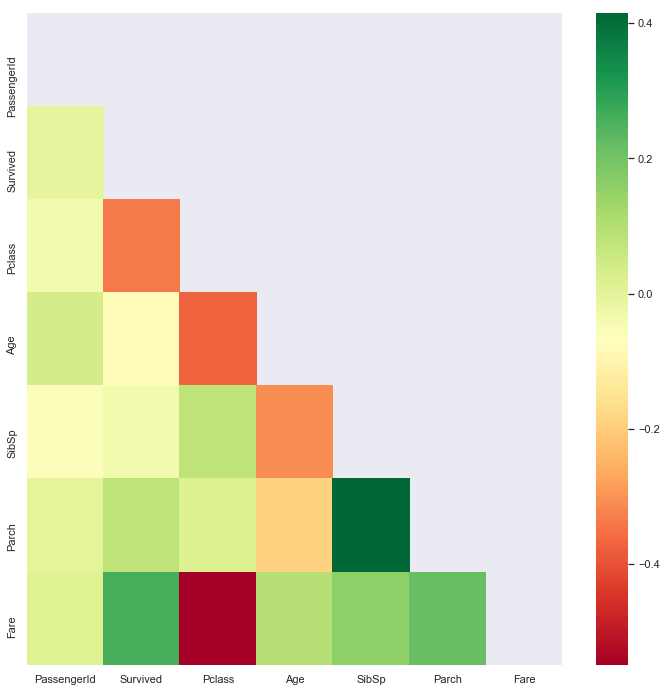

In [5]:
corr = train_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] =  True

plt.figure(figsize=(12,12))
sns.heatmap(train_df.corr(), mask=mask, cmap='RdYlGn')

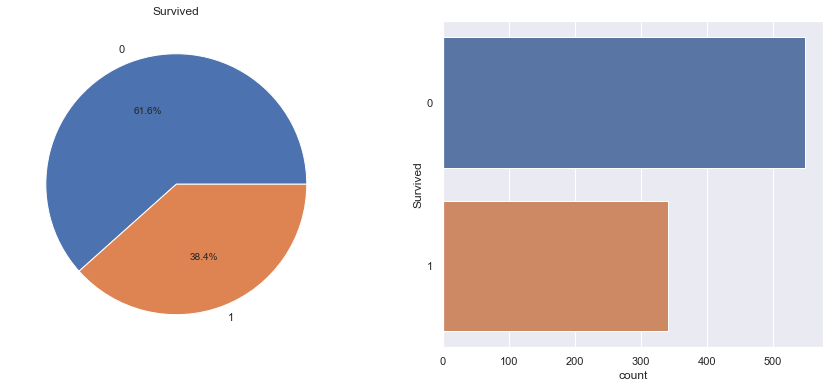

In [7]:
f, (ax0, ax1) =plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

train_df['Survived'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax0)
ax0.set_title('Survived')
ax0.set_ylabel('')

sns.countplot(y='Survived',data=train_df, ax=ax1)

### Pclass

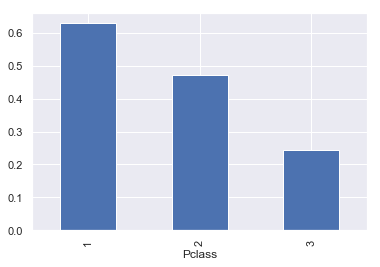

In [8]:
train_df.groupby('Pclass').mean()[['Survived']]['Survived'].plot.bar()

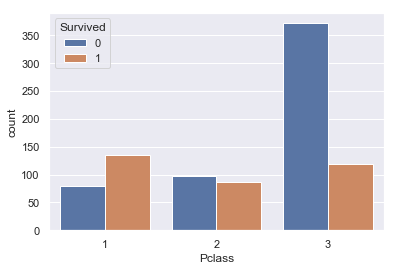

In [9]:
sns.countplot('Pclass', hue='Survived',data=train_df)

This plot looks nice!!
Let's build a function to easily see if a feature is relevant.

<Figure size 432x288 with 0 Axes>

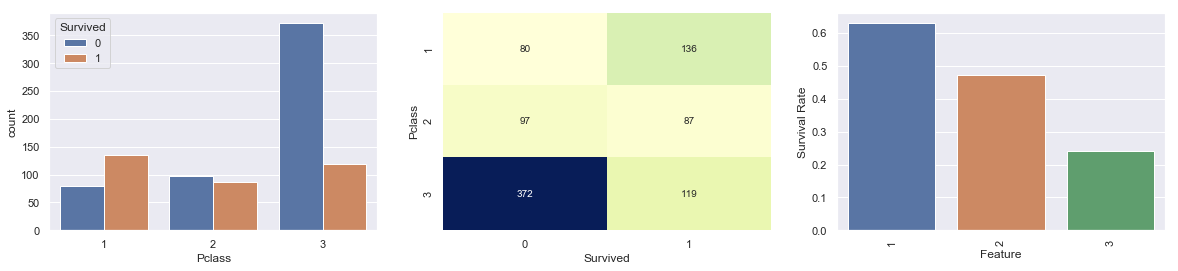

In [10]:
def check_feature_relevance(feature, y=train_df['Survived']):
    if len(feature) != len(y):
        print('Error: your feature must be the same length of the targets y')
        return
    plt.clf()
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,3,1)
    sns.countplot(feature, hue=y)

    plt.subplot(1,3,2)
    sns.heatmap(pd.crosstab(feature, y), cbar=False, annot=True, cmap="YlGnBu", fmt="d")
    
    plt.subplot(1,3,3)
    
    df = pd.DataFrame(np.c_[feature, y], columns=['Feature', 'Survival Rate'])
    df['Survival Rate'] = df['Survival Rate'].astype('int')
    
    df = df.groupby('Feature').mean().reset_index().sort_values('Survival Rate', ascending=False)    
    sns.barplot(x='Feature', y='Survival Rate',data=df)
    plt.xticks(rotation=90)

check_feature_relevance(train_df['Pclass'])

### Name

We can use the title of the person to creature a new awesome feature!

In [832]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class TitleExtractor( BaseEstimator, TransformerMixin):
    def __init__(self, rare_treshold=0.005 ):
        self.rare_treshold = rare_treshold
    
    @staticmethod
    def extract_titles(names):
        return names.str.extract('([A-Za-z]+)\.')[0]

    def fit(self, df):
        titles = self.extract_titles(df['Name'])
        titles_df = pd.DataFrame(list(titles), columns=['Title'])
        titles_count = titles_df['Title'].value_counts(normalize=True)

        self.top_titles = titles_count[titles_count >= self.rare_treshold]
        return self
        
    def transform(self, df):
        titles = self.extract_titles(df['Name'])
        titles_uniformed = titles.apply(lambda title: title if title in self.top_titles else 'rare')
        return titles_uniformed.to_numpy().reshape(-1, 1)
    
    def get_feature_names(self):
        return self.top_titles
    
title_pipeline = Pipeline([
    ('generate_titles', TitleExtractor()),
    ('encoder', OneHotEncoder())
])

<Figure size 432x288 with 0 Axes>

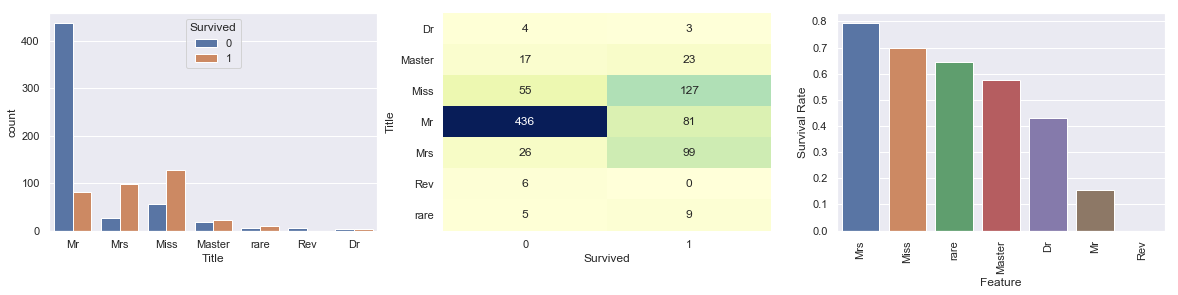

In [817]:
train_df['Title'] = TitleExtractor().fit_transform(train_df)
check_feature_relevance(train_df['Title'])

### Sex
Let's see the Sex feature relevance!

<Figure size 432x288 with 0 Axes>

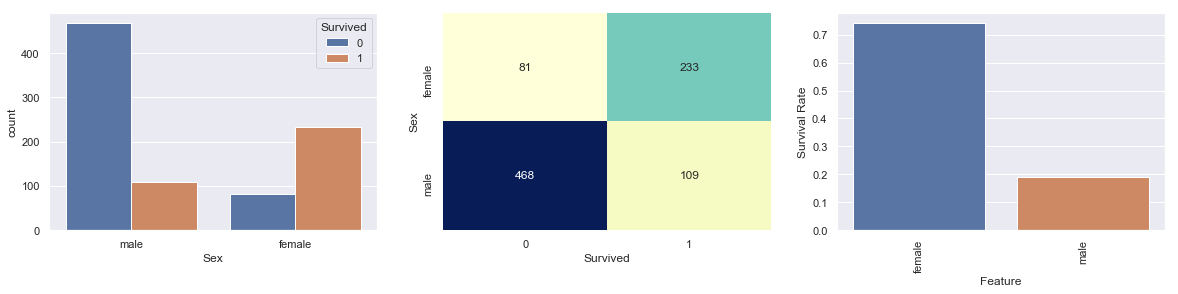

In [774]:
check_feature_relevance(train_df['Sex'])
# So, laids first was really adopted.

### Age


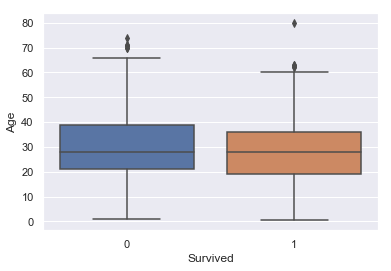

In [12]:
sns.boxplot(x='Survived', y='Age', data=train_df)

In [41]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

def fill_age_na(df):
    age_deep_groups = train_df.groupby(['Pclass', 'SibSp','Sex'])['Age'].mean().reset_index()
    age_pclass_groups = train_df.groupby('Pclass')['Age'].mean()
    
    age_deep_groups['Age'] = age_deep_groups.apply(lambda row: row['Age'] if pd.notnull(row['Age']) else age_pclass_groups[row['Pclass']], axis=1)
    age_deep_groups = age_deep_groups.set_index(['Pclass', 'SibSp', 'Sex'])
    
    return df.apply(lambda row:
                        row['Age'] if pd.notnull(row['Age'])
                        else age_deep_groups.loc[(row['Pclass'], row['SibSp'], row['Sex'])]['Age'], axis=1).to_numpy().reshape(-1, 1)

age_filler = FunctionTransformer(fill_age_na)

age_pipeline = Pipeline([
    ('age_filler', age_filler),
    ('scaler', MinMaxScaler())
])

### Sibsp

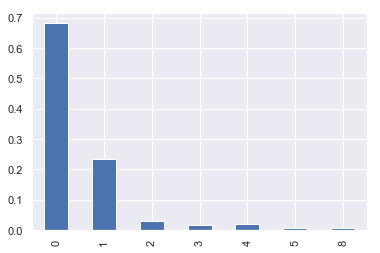

In [93]:
train_df['SibSp'].value_counts(normalize=True).sort_index().plot.bar()

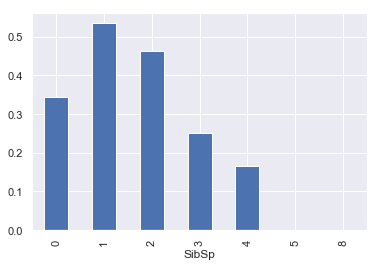

In [99]:
train_df.groupby('SibSp')['Survived'].mean().plot.bar()

### Parch

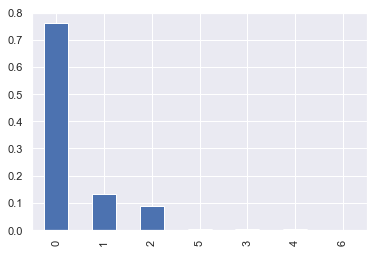

In [101]:
train_df['Parch'].value_counts(normalize=True).plot.bar()

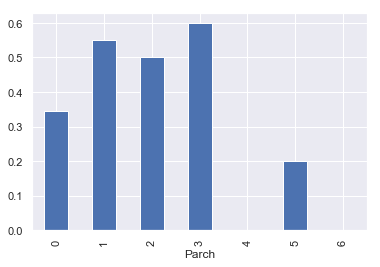

In [102]:
train_df.groupby('Parch')['Survived'].mean().plot.bar()

In [218]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']
train_df.groupby('FamilySize')['Survived'].mean()

# People alone had an 30% survival rate
# FamilySizes between 1~3 people where more propense to survive
# Large families almost never survive

FamilySize
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

## Family Size Feature
We can build a Family Size feature with Parch and SibSp columns

In [781]:
from sklearn.preprocessing import FunctionTransformer

def _is_alone(size):
    if size == 0:
        return 1
    return 0

def quantify_family(df):
    df['FamilySize'] = df.apply(lambda row: row['Parch'] + row['SibSp'], axis=1)
    return df['FamilySize'].apply(_is_alone).to_numpy().reshape(-1,1)

family_pipeline = Pipeline([
    ('family_size', FunctionTransformer(quantify_family)),
    ('onehot_encoder', OneHotEncoder())
])

family_pipeline.fit_transform(train_df).toarray()

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## Fare

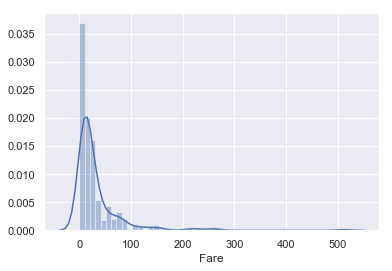

In [782]:
sns.distplot(train_df['Fare'])

In [783]:
train_df.corr()['Survived']['Fare']
# There is a nice correlation

0.2573065223849618

2  :  0.281399637410973
3  :  0.3126182940037795
4  :  0.25911457182008524
5  :  0.2648041102519193
6  :  0.23787034178943214
7  :  0.23869570946482913


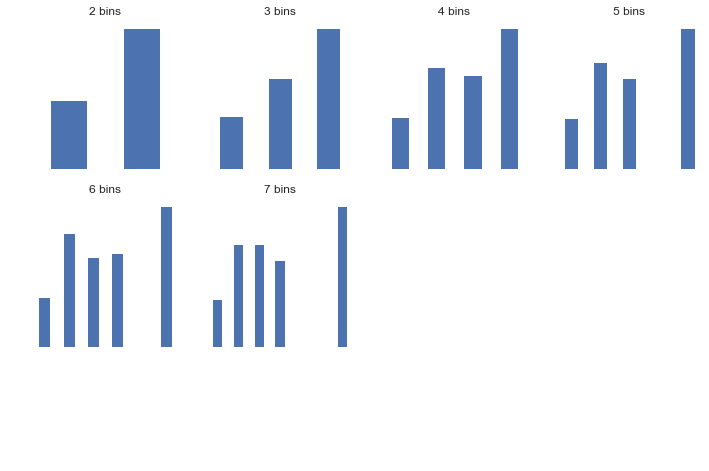

In [787]:
plt.figure(figsize=(12,6))
for i in range(2,8):
    plt.subplot(2, 4, i-1)
    train_df['FareBinTemp'] = pd.cut(train_df['Fare'], bins=i)
    group_df = train_df.groupby('FareBinTemp')['Survived'].mean()
    group_df.plot.bar()
    plt.title(f'{i} bins')
    plt.axis('off')
    print(i,' : ',group_df.std())

In [809]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer

fare_pipeline = Pipeline([
    ('fill_na_mode', SimpleImputer(strategy='most_frequent')),
    ('4bins', KBinsDiscretizer(n_bins=3, strategy='uniform', encode='ordinal')),
])

# fare_pipeline.fit_transform(train_df[['Fare']])

## Cabin?

In [419]:
train_df['CabinLetter'] = train_df['Cabin'].str.extract('([A-Za-z])')

train_df.groupby('CabinLetter')['Survived'].agg(['count', 'mean'])

,count,mean
CabinLetter,,
A,15,0.466667
B,47,0.744681
C,59,0.593220
D,33,0.757576
E,32,0.750000
F,13,0.615385
G,4,0.500000
T,1,0.000000


In [740]:
train_df['HasCabin'] = train_df['Cabin'].notnull().astype('int')

In [742]:
train_df.groupby('HasCabin')['Survived'].mean()

HasCabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64

## Embarked

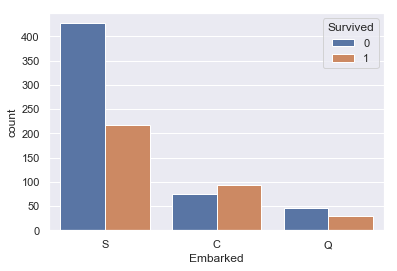

In [432]:
sns.countplot('Embarked', hue='Survived',data=train_df)

In [455]:
embarked_pipeline = Pipeline([
    ('mode_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())
])
embarked_pipeline.fit_transform(train_df[['Embarked']])
# train_df['Embarked']

<891x3 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

### Full Pipeline

In [833]:
from sklearn.compose import ColumnTransformer

features_columns = ['Name', 'Age', 'Pclass', 'SibSp', 'Sex', 'Parch', 'Fare', 'Embarked']
target_column = 'Survived'

full_pipeline = ColumnTransformer([
    ('title', title_pipeline, ['Name']),
    ('age_fill', age_pipeline, ['Age', 'Pclass', 'SibSp','Sex']),
    ('family_pipe', family_pipeline, ['Parch', 'SibSp']),
    ('fare_pipe', fare_pipeline, ['Fare']),
    ('embarked_pipe', embarked_pipeline, ['Embarked']),
    ('onehot', OneHotEncoder(), ['Sex', 'Pclass']),
])

full_pipeline.fit(full_df[features_columns])

# Transform train set
print(full_pipeline.transform(train_df[features_columns]).shape)

# Transform test set
print(full_pipeline.transform(test_df[features_columns]).shape)

X_train = full_pipeline.transform(train_df[features_columns])
y_train = train_df[target_column]

X_test = full_pipeline.transform(test_df[features_columns])

(891, 19)
(418, 19)


In [834]:
full_pipeline.get_feature_names()

AttributeError: Transformer title (type Pipeline) does not provide get_feature_names.

In [810]:
dir(full_pipeline)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_columns',
 '_df_columns',
 '_feature_names_in',
 '_fit_transform',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_has_str_cols',
 '_hstack',
 '_iter',
 '_log_message',
 '_more_tags',
 '_n_features',
 '_remainder',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transformers',
 '_update_fitted_transformers',
 '_validate_column_callables',
 '_validate_data',
 '_validate_features',
 '_validate_names',
 '_v

## It's Training Time!
First, let's see which models performs better with the default sklearn hyperparameters

In [804]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [828]:
full_pipeline.get_feature_names()

AttributeError: Transformer title (type Pipeline) does not provide get_feature_names.

In [802]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

classifiers = [
    ('Random Forest', RandomForestClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('Gradient Boosting Trees', GradientBoostingClassifier()),  
    ('SVM', SVC()),
    ('LinearSVC', LinearSVC()),
    ('KNN',KNeighborsClassifier()),
    ('XGBoost',XGBClassifier()),
    ('Neural Net', MLPClassifier())
]


for name, clf in classifiers:
    accuracies = cross_val_score(clf, X_train, y_train, cv=5)
    print(name,' : ',accuracies.mean())

Random Forest  :  0.7789278764672651
Extra Trees  :  0.7778105580315109
Logistic Regression  :  0.8069549934090767
Gradient Boosting Trees  :  0.8159688657334756
SVM  :  0.815931203314293
LinearSVC  :  0.795744146632352
KNN  :  0.8036218693114054
XGBoost  :  0.810344611135522


/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: Conve

Neural Net  :  0.8114807607808675


/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## It's Tuning Time
Lets pick the best models and tune then!

Models picked:
1) LogisticRegression<br>
2) GradientBoostingClassifier<br>
3) LinearSVC<br>
4) KNN<br>
5) XGBoost

In [701]:
# 1) LogistRegression
from sklearn.model_selection import GridSearchCV

lr_search = GridSearchCV(
    estimator=LogisticRegression(solver='saga', penalty='elasticnet'),
    param_grid= {
      'l1_ratio': [0, 0.25,0.5,0.75, 1],
      'C': [0.1, 0.5, 1, 5, 10]
    },
    cv=5
)
lr_search.fit(X_train, y_train)
lr_search.best_score_

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nakamu

0.8271483271608814

In [ ]:
# 2) GradientBoostingClassifier
gb_search = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid={
        'loss': ['deviance', 'exponential'],
        'n_estimators': [5, 10, 50, 100, 250, 500],
        'subsample': [0.5, 0.75, 1],
        'max_depth': [1, 3, 5, 10]
    },
    cv=5,
    n_jobs=-1
)
gb_search.fit(X_train, y_train)
gb_search.best_params_

In [703]:
# 3) Linear_SVC
svc_search = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid={
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf']
    },
    cv=5,
    n_jobs=-1
)
svc_search.fit(X_train, y_train)
svc_search.best_score_

0.8282656455966355

In [704]:
# 4) KNN
knn_search = GridSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1, n_neighbors=20),
    param_grid={
        'weights':['uniform', 'distance'],
        'n_neighbors':[2, 5, 10, 15, 20, 50],
        'leaf_size': [50, 90,100, 110, 300]
    },
    cv=5,
    n_jobs=-1
)
knn_search.fit(X_train, y_train)
knn_search.best_score_

0.832772581758835

In [758]:
# 
xgb_search = GridSearchCV(
    estimator=XGBClassifier(n_jobs=-1),
    param_grid={
        'n_estimators':[50, 100],
        'eta': [0.1, 0.3, 0.5],
        'booster':['gbtree', 'dart', 'gblinear'],
        'max_depth': [6],
        'min_child_weight':[4,5,8,],
        'sampling_method:': ['uniform, gradient_based']
    },
    cv=5,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
print(xgb_search.best_params_)
print(xgb_search.best_score_)

[19:14:37] WARNING: /workspace/src/learner.cc:480: 
Parameters: { sampling_method: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'booster': 'gbtree', 'eta': 0.5, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 50, 'sampling_method:': 'uniform, gradient_based'}
0.8350323269097985


In [759]:
# Neural Net
nn_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid={
        'activation': ['relu'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    cv=5,
    n_jobs=-1
    
)

nn_search.fit(X_train, y_train)

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']})

In [761]:
from sklearn.ensemble import VotingClassifier

final_model = VotingClassifier(
    estimators=[
        ('Linear Regression', lr_search.best_estimator_),
        ('Gradient Boosting', gb_search.best_estimator_),
        ('Suport Vector Machines', svc_search.best_estimator_),
        ('KNN', knn_search.best_estimator_),
        ('XGBoost', xgb_search.best_estimator_),
        ('Neural Net', nn_search.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)

final_model.fit(X_train, y_train)
cross_val_score(final_model, X_train, y_train, cv=5).mean()

0.812591802146758

In [762]:
df_submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_model.predict(X_test)
})
df_submission.to_csv('datasets/submission-07-07-2020_ensemble.csv', index=False)

In [691]:
df_submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': xgb_search.best_estimator_.predict(X_test)
})
df_submission.to_csv('datasets/submission-07-07-2020_xgboost.csv', index=False)